In [1]:
# Data representation and manipulation
import pandas as pd 
from sentence_transformers import SentenceTransformer 
from nltk.corpus import stopwords
import re
from utils import general
# Prediction and evaluation packages
import numpy as np 
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import hamming_loss, classification_report, confusion_matrix

In [2]:
stop_words = set(stopwords.words('english'))
# Add domain-specific stopwords
legislation_words = [
    "law",
    "provisions",
    "existing",
    "establishes",
    "requires",
    "establish",
    "require",
    "laws",
    "prohibit",
    "prohibits"
]
stop_words.update(legislation_words)

In [3]:
# Define a function to remove stopwords from text

def preprocess_text(text):
    words = re.findall(r'\b\w+\b', text.lower())  # Whitespace tokenize
    return ' '.join([w for w in words if w not in stop_words])

In [4]:
# A pretrained model finetuned on the US Code
# legal_model = SentenceTransformer("ArchitRastogi/BGE-Small-LegalEmbeddings-USCode")
# A pretrained model finetuned on 1B tokens from the internet
mini_model = SentenceTransformer('all-MiniLM-L6-v2')

In [7]:
# Create topic embeddings
# legal_embeddings = {}
mini_embeddings = {}
for topic, data in general.topic_config.items():
    # Take the centroid of the topic itself and its keywords
    contents = data["keywords"] + [topic]
    mini_embeddings[topic] = mini_model.encode(' '.join(contents))
    # legal_embeddings[topic] = np.mean(legal_model.encode(contents), axis=0)
    # mini_embeddings[topic] = np.mean(mini_model.encode(contents), axis=0)

In [6]:
# Use a weighted combination of bill title and abstract to embed the text for cosine similarity

def get_weighted_embedding(model, row, title_weight=0.8):
    title = str(row["bill_name"]) # Original bill name, make sure to cast as a string
    abstract = str(row["bill_text"]) # Bill text, recast as a string 
    title_embed = model.encode(preprocess_text(title))
    abstract_embed = model.encode(preprocess_text(abstract))
    return (title_weight * title_embed) + ((1 - title_weight) * abstract_embed)

In [8]:
# Given a pre-computed embedding and label embeddings, add any label if
# keyword is matched OR similarity exceeds the threshold
def predict_topics(row, label_embeddings, threshold=0.384):
    # Store predictions, topics from keyword-match and topics to check for similarity
    predictions = {}
    
    # Loop through the topic embeddings
    for label, embedding in label_embeddings.items():
        similarity = cosine_similarity([row.bill_embedding], [embedding])[0][0]
        predictions[label] = similarity > threshold
            
    # Add 'Other' classification if nothing has stuck
    predictions["Other"] = (not any(predictions.values()))

    # return it as a list
    return [t for t, predicted in predictions.items() if predicted]

def predict_topics_keyword_first(row, label_embeddings, threshold=0.384):
    # Store predictions, topics from keyword-match and topics to check for similarity
    predictions = {}
    
    topics_from_keywords = set()
    
    # do keyword match, then cosine similarity
    for kw in row.keyword_matches:
        found = general.keyword_to_topics.get(kw, [])
        topics_from_keywords.update(found)

    # Add hard-match topics
    for topic in topics_from_keywords:
        predictions[topic] = True

    # Loop through the topic embeddings
    for label, embedding in label_embeddings.items():
        if label in topics_from_keywords:
            continue
        else: # Only calculate cosine similarity if keyword has not already been matched
            similarity = cosine_similarity([row.bill_embedding], [embedding])[0][0]
            predictions[label] = similarity > threshold
            
    # Add 'Other' classification if nothing has stuck
    predictions["Other"] = (not any(predictions.values()))

    # return it as a list
    return [t for t, predicted in predictions.items() if predicted]

def predict_topics_cosine_first(row, label_embeddings, threshold=0.384):
    # Store predictions, topics from keyword-match and topics to check for similarity
    predictions = {}

    # Loop through the topic embeddings
    for label, embedding in label_embeddings.items():
        similarity = cosine_similarity([row.bill_embedding], [embedding])[0][0]
        predictions[label] = similarity > threshold

    # do keyword match
    topics_from_keywords = set()
    for kw in row.keyword_matches:
        found = general.keyword_to_topics.get(kw, [])
        topics_from_keywords.update(found)

    # Add hard-match topics
    for topic in topics_from_keywords:
        predictions[topic] = True
            
    # Add 'Other' classification if nothing has stuck
    predictions["Other"] = (not any(predictions.values()))

    # return it as a list
    return [t for t, predicted in predictions.items() if predicted]

In [9]:
df = pd.read_csv("techequity_dashboard_bills.csv") # manually downloaded Dashboard bills

In [10]:
# Select only necessary columns
df = df.loc[:,
    [
        "bill_number",
        "bill_name",
        "bill_text",
        "bill_topic"
    ]]

# Make sure bill topic is represented as a list, not string
from ast import literal_eval

df.bill_topic = df.bill_topic.apply(literal_eval)
df.bill_topic = df.bill_topic.apply(lambda x: ["Other"] if not x else x)
df["keyword_matches"] = df["bill_name"].str.lower().str.findall(general.global_keyword_regex)
df # Preview

,bill_number,bill_name,bill_text,bill_topic,keyword_matches
0,AB 1248,Hiring of real property: fees and charges.,Existing law regulates the hiring of real prop...,[Labor],[hiring]
1,SB 53,Artificial intelligence models: large developers.,(1) Existing law generally regulates artificia...,[AI],[artificial intelligence]
2,SB 522,Housing: tenant protections.,Existing law governs the hiring of residential...,[Housing],"[housing, tenant]"
3,AB 502,Elections: deceptive media in advertisements.,Existing law prohibits a person or entity from...,[AI],[deceptive media]
4,AB 1018,Automated decision systems.,The California Fair Employment and Housing Act...,[AI],[automated]
...,...,...,...,...,...
58,AB 279,School libraries: model library standards.,Existing law requires the State Board of Educa...,[Other],[]
59,AB 397,Personal Income Tax Law: young child tax credit.,The Personal Income Tax Law allows various cre...,[Kids],[child]
60,AB 682,Health care coverage reporting.,"Existing law, the Knox-Keene Health Care Servi...",[Health],[health care]
61,AB 412,Generative artificial intelligence: training d...,"Existing federal law, through copyright, provi...","[Data, Surveillence, Privacy, AI, Labor]","[artificial intelligence, training data]"


In [11]:
df["bill_embedding"] = df.apply(
    lambda x: get_weighted_embedding(mini_model, x),
    axis=1
)

In [12]:
df["keyword_first_prediction"] = df.apply(
    lambda x: predict_topics_keyword_first(
        x, 
        label_embeddings=mini_embeddings
    ), 
    axis=1
)

df["cosine_first_prediction"] = df.apply(
    lambda x: predict_topics_cosine_first(
        x, 
        label_embeddings=mini_embeddings
    ), 
    axis=1
)
df["cosine_only_prediction"] = df.apply(
    lambda x: predict_topics(
        x, 
        label_embeddings=mini_embeddings
    ), 
    axis=1
)

In [13]:
# No overlap in predicted topics and the current 'gold' topic is not "Other"
# df.loc[~df.topic_overlap.astype(bool) & df.bill_topic.apply(lambda x: x != ["Other"])]
df.loc[~df.keyword_matches.astype(bool)]
# df.loc[df.predicted_topics.apply(lambda x: "Disinformation" in x)]

,bill_number,bill_name,bill_text,bill_topic,keyword_matches,bill_embedding,keyword_first_prediction,cosine_first_prediction,cosine_only_prediction
8,SB 390,Community facilities district: inclusion or an...,"Existing law, the Mello-Roos Community Facilit...",[Other],[],"[0.07138873, -0.013753141, 0.024923155, 0.0416...",[Other],[Other],[Other]
12,SB 259,Fair Online Pricing Act.,The California Consumer Privacy Act of 2018 gr...,[Other],[],"[-0.05706851, -0.015436118, -0.0040004663, -0....","[Collusion, Price Fixing]","[Collusion, Price Fixing]","[Collusion, Price Fixing]"
18,AB 748,Commissioner of Financial Protection and Innov...,The California Consumer Financial Protection L...,[Other],[],"[-0.054191202, 0.054383375, -0.06914768, 0.018...",[Other],[Other],[Other]
35,AB 1355,Location privacy.,"(1) Existing law, the California Consumer Priv...",[Other],[],"[0.03950727, -0.003047233, -0.011547702, -0.02...","[Data, Surveillence, Privacy]","[Data, Surveillence, Privacy]","[Data, Surveillence, Privacy]"
36,AB 723,Real estate: digitally altered images: disclos...,"Existing law, the Real Estate Law, provides fo...",[Other],[],"[0.0020674537, 0.04273584, 0.0022380394, 0.010...",[Other],[Other],[Other]
40,SB 57,Electrical corporations: tariffs.,Existing law vests the Public Utilities Commis...,[Other],[],"[-0.052643646, -0.012158349, 0.034072127, -0.0...",[Other],[Other],[Other]
42,SB 813,Multistakeholder regulatory organizations.,"Existing law requires, on or before September ...",[Other],[],"[0.04449629, -0.041931123, -0.015178479, -0.06...",[Other],[Other],[Other]
43,AB 1170,Maintenance of the codes.,Existing law directs the Legislative Counsel t...,[Other],[],"[-0.07740823, 0.0068604485, 0.030221391, -0.02...",[Other],[Other],[Other]
45,AB 398,Personal income tax: Earned Income Tax Credit.,"The Personal Income Tax Law, in modified confo...",[Other],[],"[-0.05722301, -0.008378541, 0.029415343, -0.05...",[Other],[Other],[Other]
47,AB 325,Cartwright Act: violations.,Existing law establishes the Attorney General ...,[Other],[],"[0.023806132, 0.046615083, 0.05170132, -0.0519...",[Other],[Other],[Other]


In [14]:
# df.loc[~df.bill_topic.astype(bool), 'new_topics'].sum()
# print(df.loc[df.predicted_topics.apply(len).idxmax(), 'predicted_topics'])
# print(df.loc[df.predicted_topics.apply(len).idxmax(), 'bill_text'].replace("\\n", "\n"))
len(df.loc[df.cosine_first_prediction.apply(lambda x: x == ["Other"])])

9

In [15]:
topic_df = df[['bill_topic', 'cosine_only_prediction', 'cosine_first_prediction', 'keyword_first_prediction']]
topic_df = topic_df.rename(columns={
    'bill_topic': 'keyword-only',
    'cosine_only_prediction': 'cosine-only',
    'cosine_first_prediction': 'cosine-first',
    'keyword_first_prediction': 'keyword-first'
})

In [16]:
from collections import defaultdict

In [17]:
# Create binary matrix indicating topic presence per model per document
all_topics = list(mini_embeddings.keys()) + ["Other"]

# Initialize an empty list to store our transformed data
binary_data = []

# Loop through each document (row) in the original dataframe
for idx, row in topic_df.iterrows():
    doc_data = {}  # Store binary values for this document
    
    # For each model (column) in the dataframe
    for model in topic_df.columns:
        # For each possible topic
        for topic in all_topics:
            # Create a column name like "Model1_AI"
            col_name = f"{model}_{topic}"
            # Set to 1 if topic is present, 0 otherwise
            doc_data[col_name] = 1 if topic in row[model] else 0
    
    # Add this document's data to our collection
    binary_data.append(doc_data)

# Convert to DataFrame
binary_df = pd.DataFrame(binary_data)

In [18]:
# Initialize a dictionary to store counts
model_topic_counts = defaultdict(int)

# Loop through each document
for idx, row in topic_df.iterrows():
    # For each model
    for model in topic_df.columns:
        # For each topic this model predicted for this document
        for topic in row[model]:
            # Increment the count for this model-topic pair
            model_topic_counts[(model, topic)] += 1

# Convert to a more readable dataframe
count_df = pd.DataFrame(
    [(model, topic, count) for (model, topic), count in model_topic_counts.items()],
    columns=['Model', 'Topic', 'Count']
)

In [19]:
from itertools import combinations

model_cooccurrence = defaultdict(int)

for idx, row in topic_df.iterrows():
    # Get all pairs of models
    for m1, m2 in combinations(topic_df.columns, 2):
        # Find topics common to both models for this document
        common_topics = set(row[m1]) & set(row[m2])
        # Add the count of common topics
        model_cooccurrence[(m1, m2)] += len(common_topics)

# Convert to dataframe
model_co_df = pd.DataFrame(
    [(m1, m2, count) for (m1, m2), count in model_cooccurrence.items()],
    columns=['Model1', 'Model2', 'Common_Predictions']
)

In [20]:
topic_cooccurrence = defaultdict(int)

for idx, row in topic_df.iterrows():
    # Get all unique topics predicted for this document (across all models)
    all_topics_in_doc = set()
    for model in topic_df.columns:
        all_topics_in_doc.update(row[model])
    
    # Count all pairs of topics in this document
    for t1, t2 in combinations(all_topics_in_doc, 2):
        # Sort to avoid duplicate pairs (A,B vs B,A)
        pair = tuple(sorted((t1, t2)))
        topic_cooccurrence[pair] += 1

# Convert to dataframe
topic_co_df = pd.DataFrame(
    [(t1, t2, count) for (t1, t2), count in topic_cooccurrence.items()],
    columns=['Topic1', 'Topic2', 'Co-occurrence']
)

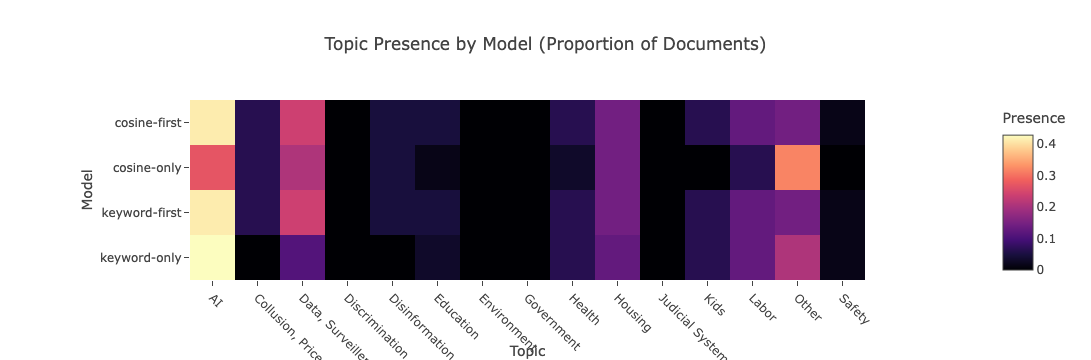

In [21]:
import plotly.express as px

# Aggregate the binary data by model and topic
heatmap_data = binary_df.mean().reset_index()
heatmap_data.columns = ['Model_Topic', 'Presence']
heatmap_data[['Model', 'Topic']] = heatmap_data['Model_Topic'].str.split('_', expand=True)

# Create pivot table for heatmap
heatmap_pivot = heatmap_data.pivot(index='Model', columns='Topic', values='Presence')

# Create heatmap
fig = px.imshow(heatmap_pivot,
                color_continuous_scale='Magma',
                title='Topic Presence by Model (Proportion of Documents)',
                labels=dict(x="Topic", y="Model", color="Presence"))
fig.update_layout(xaxis={'tickangle': 45})
fig.show()

In [22]:
color_discrete_map = {
    'cosine-only': 'rgb(255,0,0)', 
    'keyword-only': 'rgb(0,255,0)', 
    'keyword-first': 'rgb(0,0,255)', 
    'cosine-first': 'rgb(0,0,0)'}

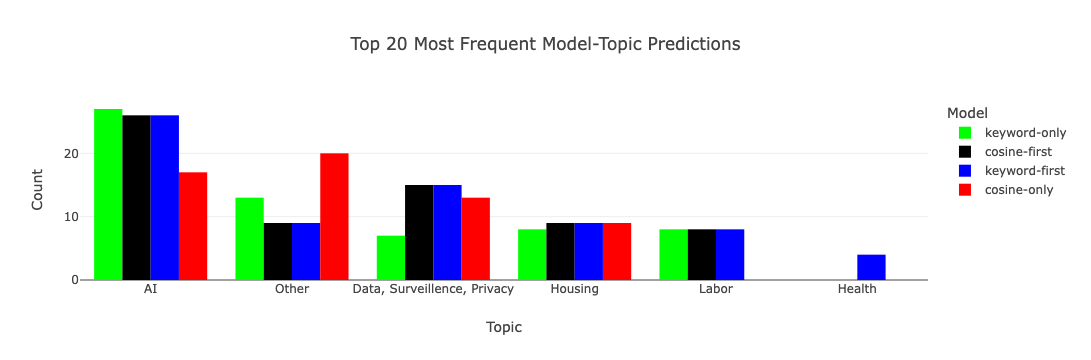

In [23]:
# Sort and get top predictions
top_predictions = count_df.sort_values('Count', ascending=False).head(20)

# Create bar chart
fig = px.bar(top_predictions,
             x='Topic',
             y='Count',
             barmode='group',
             color='Model',
             color_discrete_map=color_discrete_map,
             title='Top 20 Most Frequent Model-Topic Predictions')
fig.update_layout(xaxis={'categoryorder': 'total descending'})
fig.show()

In [24]:
topic_color_map = {
    'Labor': 'rgb(255, 0, 0)',    # Red
    'Housing': 'rgb(0, 255, 0)',    # Green
    'AI': 'rgb(0, 0, 255)',    # Blue
    'Discrimination': 'rgb(255, 255, 0)',  # Yellow
    'Education': 'rgb(0, 255, 255)',  # Cyan
    'Environment': 'rgb(255, 0, 255)',  # Magenta
    'Health': 'rgb(128, 0, 0)',    # Dark Red
    'Data, Surveillence, Privacy': 'rgb(0, 128, 0)',    # Dark Green
    'Disinformation': 'rgb(0, 0, 128)',    # Dark Blue
    'Judicial System': 'rgb(255, 165, 0)',  # Orange
    'Safety': 'rgb(75, 0, 130)',   # Indigo
    'Kids': 'rgb(238, 130, 238)',# Violet
    'Government': 'rgb(255, 255, 255)',# White
    'Collusion, Price Fixing': 'rgb(0, 0, 0)',      # Black
    'Other': 'rgb(192, 192, 192)' # Silver
}

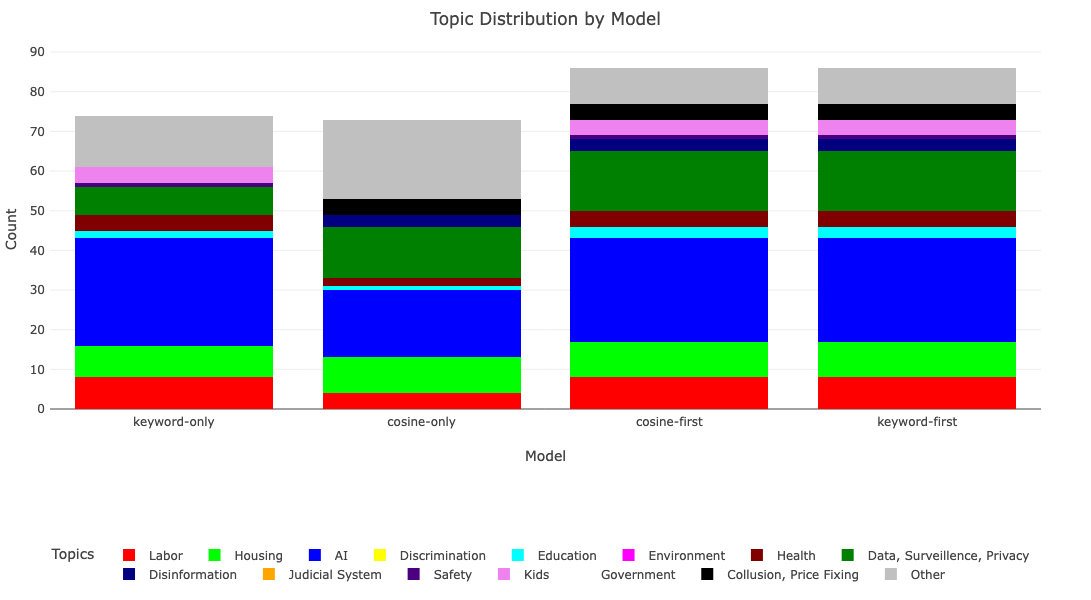

In [25]:
# Prepare data for stacked bar chart
stacked_data = []
for model in topic_df.columns:
    topic_counts = defaultdict(int)
    for topics in topic_df[model]:
        for topic in topics:
            topic_counts[topic] += 1
    for topic in all_topics:
        stacked_data.append({
            'Model': model,
            'Topic': topic,
            'Count': topic_counts.get(topic, 0)
        })
stacked_df = pd.DataFrame(stacked_data)

# Create stacked bar chart
fig = px.bar(stacked_df, 
             x='Model', 
             y='Count', 
             color='Topic',
             color_discrete_map=topic_color_map,
             title='Topic Distribution by Model',
             barmode='stack')

# Adjust layout to make room for legend
fig.update_layout(
    legend=dict(
        orientation="h",  # Horizontal legend
        yanchor="bottom",
        y=-0.5,  # Position below x-axis
        xanchor="center",
        x=0.5,
        title_text='Topics'
    ),
    margin=dict(l=50, r=50, b=150, t=50, pad=4),  # Increase bottom margin
    height=600,  # Increase figure height
    width=1000   # Increase figure width
)
# Save with higher resolution
fig.show()

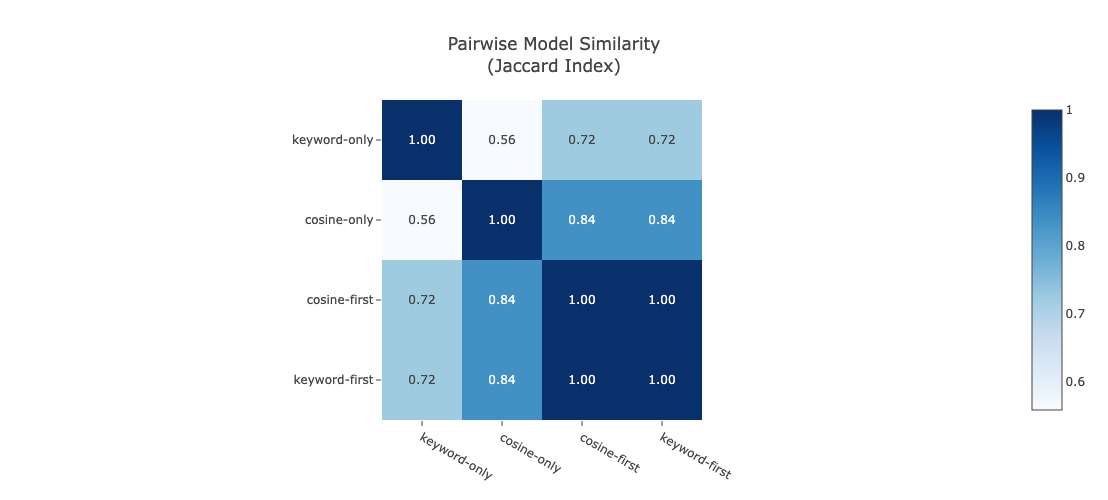

In [25]:
from sklearn.metrics import jaccard_score

# Create a matrix showing % of overlapping predictions between each model pair
overlap_matrix = pd.DataFrame(index=topic_df.columns, columns=topic_df.columns)

for model1 in topic_df.columns:
    for model2 in topic_df.columns:
        # Calculate Jaccard similarity (intersection over union)
        similarities = []
        for idx, row in topic_df.iterrows():
            set1 = set(row[model1])
            set2 = set(row[model2])
            if len(set1 | set2) > 0:  # Avoid division by zero
                similarities.append(len(set1 & set2) / len(set1 | set2))
        overlap_matrix.loc[model1, model2] = np.mean(similarities)

# Visualize
fig = px.imshow(overlap_matrix.astype(float),
                x=overlap_matrix.columns,
                y=overlap_matrix.index,
                color_continuous_scale='Blues',
                text_auto=".2f",
                title="Pairwise Model Similarity<br>(Jaccard Index)")
fig.update_layout(width=500, height=500)
fig.show()